
# Reprojecting Using a Spherical Screen

This example demonstrates how you can reproject an image as if it lies on the
inside of a spherical screen and the observer is not at the center of the
sphere.  This functionality is primarily for visualization purposes, since
features in the image are unlikely to actually lie on this spherical screen.

You will need [reproject](https://reproject.readthedocs.io/en/stable/)_ v0.6
or higher installed.


In [1]:
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import SphericalScreen, PlanarScreen
from sunpy.data.sample import AIA_171_IMAGE

/Users/wtbarnes/mambaforge/envs/ar-evolution-survey/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will use one of the AIA images from the sample data.  We fix the
range of values for the Map's normalizer.



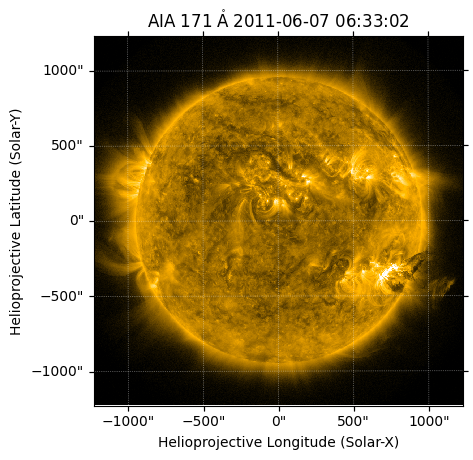

In [2]:
aia_map = sunpy.map.Map(AIA_171_IMAGE)
aia_map.plot_settings['norm'].vmin = 0
aia_map.plot_settings['norm'].vmax = 10000

fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax)
plt.show()

Let's define a new observer that is well separated from Earth.



In [3]:
new_observer = SkyCoord(70*u.deg, 20*u.deg, 1*u.AU, obstime=aia_map.date,
                        frame='heliographic_stonyhurst')

Create a WCS header for this new observer using helioprojective
coordinates.



In [4]:
out_shape = aia_map.data.shape

out_ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime=new_observer.obstime,
                         frame='helioprojective', observer=new_observer,
                         rsun=aia_map.coordinate_frame.rsun)
out_header = sunpy.map.make_fitswcs_header(
    out_shape,
    out_ref_coord,
    scale=u.Quantity(aia_map.scale),
    instrument=aia_map.instrument,
    wavelength=aia_map.wavelength
)

If you reproject the AIA Map to the perspective of the new observer,
the default assumption is that the image lies on the surface of the
Sun.  However, the parts of the image beyond the solar disk cannot
be mapped to the surface of the Sun, and thus do not show up in the
output.



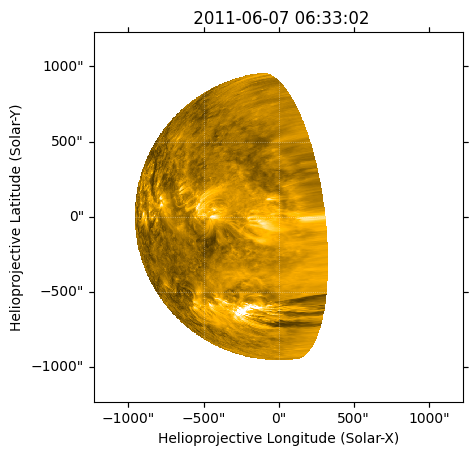

In [5]:
outmap_default = aia_map.reproject_to(out_header)

fig = plt.figure()
ax = fig.add_subplot(projection=outmap_default)
outmap_default.plot(axes=ax)
plt.show()

You can use the different assumption that the image lies on the
surface of a spherical screen centered at AIA, with a radius equal
to the Sun-AIA distance.  The curvature of the spherical screen is
not obvious in this plot due to the relatively small field of view
of AIA (compared to, say, a coronagraph).



In [50]:
#with PlanarScreen(aia_map.observer_coordinate, distance_from_center=1e-2*u.R_sun):
#    outmap_screen_all = aia_map.reproject_to(out_header)
import numpy as np
stretched_maps = []
for eps in np.logspace(-2, -3, 10):
    with PlanarScreen(aia_map.observer_coordinate,
                      only_off_disk=True,
                      distance_from_center=eps*aia_map.rsun_meters):
        outmap_screen_all = aia_map.reproject_to(out_header)
        stretched_maps.append(outmap_screen_all)

#fig = plt.figure()
#ax = fig.add_subplot(projection=outmap_screen_all)
#outmap_screen_all.plot(axes=ax)
#plt.show()

In [51]:
stretched_maps = sunpy.map.Map(stretched_maps, sequence=True)

In [46]:
from IPython.display import HTML

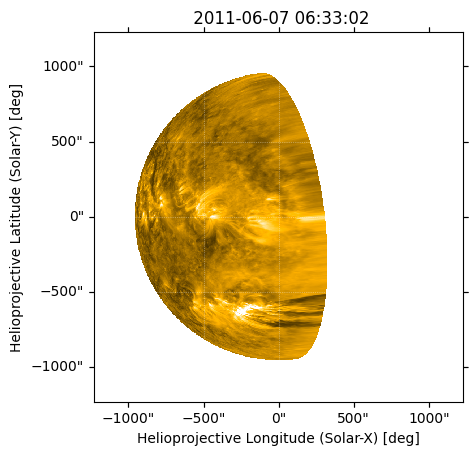

In [52]:
ani = stretched_maps.plot()

In [49]:
ani.save('stretchy-sun.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


In [53]:
HTML(ani.to_jshtml())

Finally, you can specify that the spherical-screen assumption should
be used for only off-disk parts of the image, and continue to map
on-disk parts of the image to the surface of the Sun.



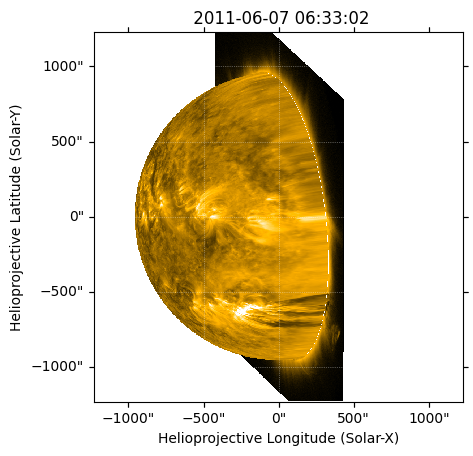

In [22]:
with PlanarScreen(aia_map.observer_coordinate, only_off_disk=True, distance_from_center=1e-3*u.R_sun):
    outmap_screen_off_disk = aia_map.reproject_to(out_header)

fig = plt.figure()
ax = fig.add_subplot(projection=outmap_screen_off_disk)
outmap_screen_off_disk.plot(axes=ax)
plt.show()